# Project

This Workbook includes the sentiment analysis and the categorisation

## Imports

In [ ]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import torch
from collections import Counter
from gensim import corpora
from gensim.models import LdaMulticore
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud

nltk.download('stopwords')

%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
tqdm.pandas()

## Pre-Processing

Reviewing, cleaning, modifying

In [ ]:
# load datsset and have a quick look on the data we have
data = pd.read_csv('lists/reviews.csv', sep=',', low_memory=False)
data.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [ ]:
# Let's have a look on the dataset size and types of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

### Cleanup dataset

In [ ]:
# cleaning unnecessary columns
data = data.drop(['id', 'asins', 'keys', 'manufacturer', 'brand', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.date',
                  'reviews.didPurchase', 'reviews.userCity', 'reviews.username', 'reviews.userProvince',
                  'reviews.sourceURLs', 'reviews.id', 'reviews.numHelpful', 'reviews.dateAdded'], axis=1)
data.head()

,name,brand,categories,reviews.doRecommend,reviews.rating,reviews.text,reviews.title
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5.0,This product so far has not disappointed. My c...,Kindle
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5.0,great for beginner or experienced person. Boug...,very fast
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids


In [ ]:
# check if there are duplicated rows
data.duplicated().sum()

0

In [ ]:
# check if there are rows with blank values
data.isnull().sum()

,0
name,6760
brand,0
categories,0
reviews.doRecommend,594
reviews.rating,33
reviews.text,1
reviews.title,6


In [ ]:
# remove row if name or reviews text or reviews.rating is blank
data = data[data['name'].notna()]
data = data[data['reviews.text'].notna()]
data = data[data['reviews.rating'].notna()]

In [ ]:
# make ratings to ints, because they only .0 floats
data['reviews.rating'] = data['reviews.rating'].astype(int)

In [ ]:
# reset index after remove some rows
data.reset_index(drop=True)

,name,brand,categories,reviews.doRecommend,reviews.rating,reviews.text,reviews.title
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5,This product so far has not disappointed. My c...,Kindle
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5,great for beginner or experienced person. Boug...,very fast
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,4,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",True,5,I bought this for my grand daughter when she c...,Fantastic Tablet for kids
...,...,...,...,...,...,...,...
27862,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",True,5,This is my new favorite device. While not perf...,My new favorite product
27863,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",True,5,I got this to basically experiment with. Strai...,Lots of potential!!!
27864,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",True,4,Good product that does the basics. Too bad you...,Good First Generation Product
27865,New Amazon Kindle Fire Hd 9w Powerfast Adapter...,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",False,3,This is great for a connected home. People who...,"Great for a ""connected home"""


In [ ]:
# Make the product names a bit prettier, by removing ",,,", newlines and doubled spaces

data['name'] = data['name'].str.replace('\r\n', ' ', regex=False)
data['name'] = data['name'].str.replace(',,,', '', regex=False)
data['name'] = data['name'].str.replace('  ', ' ', regex=False)

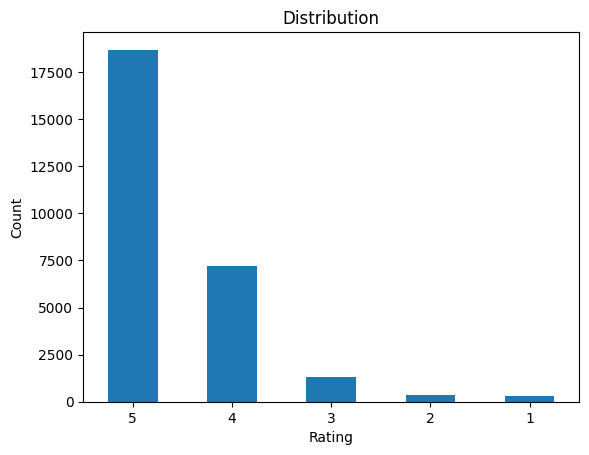

In [ ]:
# plot the distribution of ratings
data['reviews.rating'].value_counts().plot(kind='bar')
plt.title('Distribution')
plt.xticks(rotation=0)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Sentiment Analysis

### Helper Methods

In [ ]:
def combine_text(row, rating=True):
    """Combines three columns into a new column with conditional recommendation text.

    Args:
      row: The input DataFrame.
      rating: Rating information will be appended

    Returns:
      The DataFrame with the new column added.
    """

    recommend_col = 'I would not recommend' if not row['reviews.doRecommend'] else ''
    rating_col = f"Rating: {row['reviews.rating']}/5"

    if rating:
        return f"{row['reviews.text']} {recommend_col} | {rating_col}"
    else:
        return f"{row['reviews.text']} {recommend_col}"

In [ ]:
def map_roberta_label(label):
    """Maps the label to the corresponding sentiment.

    Args:
      label: The label to map.

    Returns:
      The mapped sentiment.
    """

    return {'LABEL_0': 'negative',
            'LABEL_1': 'neutral',
            'LABEL_2': 'positive'}[label]

In [ ]:
def map_bert_label(label):
    """Maps the label to the corresponding sentiment.

    Args:
      label: The label to map.

    Returns:
      The mapped sentiment.
    """

    return {0: 'negative',
            1: 'negative',
            2: 'neutral',
            3: 'positive',
            4: 'positive'}[label]

In [ ]:
def analyze_roberta_sentiment(review, classifier, tokenizer):
    """Analyzes the sentiment of a review using a sentiment classifier.

    Args:
      review: The review text.
      classifier: The sentiment classifier.
      tokenizer: The used tokenizer

    Returns:
      The sentiment label.
    """

    max_length = 512

    # Tokenisation and shortening to the maximum length
    tokens = tokenizer(review, truncation=True, padding=True, max_length=max_length, return_tensors="pt")

    # Perform sentiment analysis for the shortened text
    label = classifier(tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True))[0]['label']
    return map_roberta_label(label)

In [ ]:
def analyze_bert_sentiment(review, classifier, tokenizer):
    """Analyzes the sentiment of a review using a sentiment classifier.

    Args:
      review: The review text.
      classifier: The sentiment classifier.
      tokenizer: The used tokenizer

    Returns:
      The sentiment label.
    """

    max_length = 512

    # Tokenisation and shortening to the maximum length
    tokens = tokenizer(review, truncation=True, padding=True, max_length=max_length, return_tensors="pt").to(device)

    # Perform sentiment analysis for the shortened text
    logits = classifier(**tokens).logits
    predicted_index = torch.argmax(logits, dim=1).item()
    return map_bert_label(predicted_index)

### Pre-Processing

In [ ]:
# Add an info when it's not recommended and the rating to the review (w = with)
data['combined_text_w_rating'] = data.apply(combine_text, axis=1)

# Add an info when it's not recommended and supress the rating to do not add a bias to the bert training (wo = without)
data['combined_text_wo_rating'] = data.apply(combine_text, axis=1, args=False)

In [ ]:
# define a sentiment by the rating of the user for the product
review_mapping = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}

data['reviews.sentiment'] = data['reviews.rating'].map(review_mapping)

### Train

#### cardiffnlp/twitter-roberta-base-sentiment

ROBERTA based

In [ ]:
classifier = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment', device=device)
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
data['sentiment_roberta'] = data['combined_text_w_rating'].progress_apply(analyze_roberta_sentiment, args=(classifier, tokenizer))

100%|██████████| 27867/27867 [05:27<00:00, 85.11it/s]


In [ ]:
# Check the results
data['sentiment_roberta'].value_counts()

,count
sentiment_roberta,
positive,25009
negative,1679
neutral,1179


In [ ]:
# Take a quick manual look at the predicted sentiments
sample_reviews = data.groupby('sentiment_roberta').apply(lambda x: x.sample(n=5, random_state=2))
sample_reviews['reviews.text']

<ipython-input-99-d2a940a3e394>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_reviews = data.groupby('sentiment_roberta').apply(lambda x: x.sample(n=5, random_state=2))


sentiment_roberta       
negative           23656    I could have done without it. You need to inst...
                   12600    Can not print from this device...Using the tou...
                   8079     Good for the price. A very basic tablet with b...
                   10357    Need Amazon account and bank account to use ta...
                   7259     Good Quality tablet but the only drawback is t...
neutral            25613    Loud enough to keep a few guess entertained, i...
                   4405     Camera a little lower quality and cpu speed a ...
                   9259     Purchased as a gift for grandchildren after co...
                   17244    No instructions on adding the memory card and ...
                   2184     the fire hd is great for reading kindle books ...
positive           21079    Kindle Oasis is very light, with 4 gb of memor...
                   2676     All four of my kids have this Kindle. They doe...
                   15788    Initially we purchased the Kids Kindle Fire fo...
                   14332    We bought this for our 3 year old because she ...
                   2080     Great screen resolution and easy to use. Batte...
Name: reviews.text, dtype: object

#### LiYuan/amazon-review-sentiment-analysis

BERT based



In [ ]:
classifier = AutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
classifier.to(device)
tokenizer = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
data['sentiment_bert'] = data['combined_text_wo_rating'].progress_apply(analyze_bert_sentiment, args=(classifier, tokenizer))

100%|██████████| 27867/27867 [05:01<00:00, 92.42it/s]


In [ ]:
# Check the results
data['sentiment_bert'].value_counts()

,count
sentiment_bert,
positive,25847
neutral,1303
negative,717


In [ ]:
# Take a quick manual look at the predicted sentiments
sample_reviews = data.groupby('sentiment_bert').apply(lambda x: x.sample(n=5, random_state=2))
sample_reviews['reviews.text']

<ipython-input-103-89ac27ac97a9>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_reviews = data.groupby('sentiment_bert').apply(lambda x: x.sample(n=5, random_state=2))


sentiment_bert       
negative        8773     I honestly didn't care for it. The newest vers...
                9760     This product is a great product as long as the...
                14651    My granddaughter used her phone constantly to ...
                4057     Gave as a Christmas gift. Don't know how good ...
                16756    After owning the kids Samsung, this seems conf...
neutral         5333     My daughter's Google tablet had run its course...
                10662    I had to spend a lot of time figuring out how ...
                12618    Bought this tab for the $40 dollar sale price ...
                7693     Good tablet to purchase for a first time table...
                13881    Don't know much about this item. I purchased i...
positive        18478    its a very good product that I am glad I bough...
                14040    This was brought for husband, he wore out his ...
                7524     Bought for a Christmas gift and my nephews lov...
                3344                  It's a charger, what else can I say.
                1741     I'm not going to say this is the best tablet o...
Name: reviews.text, dtype: object

### Evaluate

In [ ]:
data['reviews.sentiment'].value_counts()

,count
reviews.sentiment,
positive,25913
neutral,1289
negative,665


In [ ]:
# compare the roberta and bert sentiment with the rating of the review
accuracy = (data['reviews.sentiment'] == data['sentiment_roberta']).mean()
print(f"Roberta Accuracy: {accuracy:.4f}")

accuracy = (data['reviews.sentiment'] == data['sentiment_bert']).mean()
print(f"Bert Accuracy: {accuracy:.4f}")

Roberta Accuracy: 0.8996
Bert Accuracy: 0.9951


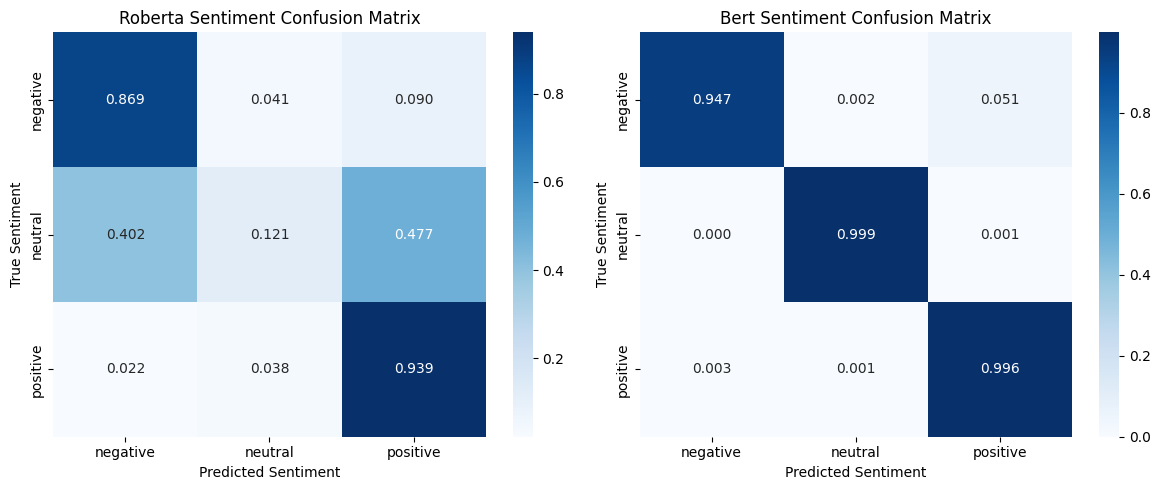

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# set labels
labels = ['negative', 'neutral', 'positive']

cm_roberta = confusion_matrix(data['reviews.sentiment'], data['sentiment_roberta'], normalize='true')
cm_bert = confusion_matrix(data['reviews.sentiment'], data['sentiment_bert'], normalize='true')

# Plotting the confusion matrices using Seaborn heatmap
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Roberta confusion matrix
sns.heatmap(cm_roberta, annot=True, fmt='.3f', cmap='Blues', ax=axes[0],
            xticklabels=labels, yticklabels=labels)
axes[0].set_title('Roberta Sentiment Confusion Matrix')
axes[0].set_xlabel('Predicted Sentiment')
axes[0].set_ylabel('True Sentiment')

# Bert confusion matrix
sns.heatmap(cm_bert, annot=True, fmt='.3f', cmap='Blues', ax=axes[1],
            xticklabels=labels, yticklabels=labels)
axes[1].set_title('Bert Sentiment Confusion Matrix')
axes[1].set_xlabel('Predicted Sentiment')
axes[1].set_ylabel('True Sentiment')

plt.tight_layout()
plt.show()

Bert made a great job, so use those results as final result

In [ ]:
data = data.rename(columns={'sentiment_bert': 'predicted_sentiment'})

In [ ]:
# let's remove now everything what's maybe not needed anymore
data = data.drop(['sentiment_roberta', 'reviews.doRecommend', 'reviews.sentiment', 'combined_text_w_rating', 'combined_text_wo_rating'], axis=1)
data.head()

,name,brand,categories,reviews.rating,reviews.text,reviews.title,predicted_sentiment
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,This product so far has not disappointed. My c...,Kindle,positive
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,great for beginner or experienced person. Boug...,very fast,positive
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,positive
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",4,I've had my Fire HD 8 two weeks now and I love...,Good!!!,positive
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,positive


After setting the sentiment, save the data to be able to start from that point later.

In [ ]:
data.to_csv('lists/reviews_with_sentiment.csv', index=False)

In [ ]:
# load the data
data = pd.read_csv('lists/reviews_with_sentiment.csv', sep=',', low_memory=False)
data.head()

,name,brand,categories,reviews.rating,reviews.text,reviews.title,predicted_sentiment
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,This product so far has not disappointed. My c...,Kindle,positive
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,great for beginner or experienced person. Boug...,very fast,positive
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,positive
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",4,I've had my Fire HD 8 two weeks now and I love...,Good!!!,positive
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,positive


## Categorizing

In [ ]:
data['categories'].value_counts()

,count
categories,
"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys",10966
"Stereos,Remote Controls,Amazon Echo,Audio Docks & Mini Speakers,Amazon Echo Accessories,Kitchen & Dining Features,Speaker Systems,Electronics,TVs Entertainment,Clearance,Smart Hubs & Wireless Routers,Featured Brands,Wireless Speakers,Smart Home & Connected Living,Home Security,Kindle Store,Home Automation,Home, Garage & Office,Home,Voice-Enabled Smart Assistants,Virtual Assistant Speakers,Portable Audio & Headphones,Electronics Features,Amazon Device Accessories,iPod, Audio Player Accessories,Home & Furniture Clearance,Consumer Electronics,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Smart Hubs,Home Safety & Security,Voice Assistants,Alarms & Sensors,Amazon Devices,Audio,Holiday Shop",5948
"Walmart for Business,Office Electronics,Tablets,Office,Electronics,iPad & Tablets,Windows Tablets,All Windows Tablets,Computers & Tablets,E-Readers & Accessories,E-Readers,eBook Readers,Kindle E-readers,Computers/Tablets & Networking,Tablets & eBook Readers,Electronics Features,Books & Magazines,Book Accessories,eReaders,TVs & Electronics,Computers & Laptops,Tablets & eReaders",3176
"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets",2814
"Tablets,Fire Tablets,Computers & Tablets,All Tablets",1699
"Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets",1038
"Walmart for Business,Office Electronics,Tablets,Electronics,iPad & Tablets,All Tablets,Computers & Tablets,E-Readers & Accessories,Kindle E-readers,Electronics Features,eBook Readers,See more Amazon Kindle Voyage (Wi-Fi),See more Amazon Kindle Voyage 4GB, Wi-Fi 3G (Unlocked...",580
"Amazon Devices & Accessories,Amazon Device Accessories,Power Adapters & Cables,Kindle Store,Kindle E-Reader Accessories,Kindle Paperwhite Accessories",401
"Electronics Features,Fire Tablets,Computers & Tablets,Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers",372


In [ ]:
def category_counts(column):
    all_categories = []
    for category_string in data[column]:
        categories = category_string.split(',')
        all_categories.extend([cat.strip() for cat in categories])

    category_counts = Counter(all_categories)
    category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])
    category_df = category_df.sort_values(by='Count', ascending=False)

    return category_df

In [ ]:
category_counts('categories')

,Count
Electronics,34895
Computers & Tablets,21462
Tablets,21126
All Tablets,18156
iPad & Tablets,17784
...,...
Fire TV,3
Tablet Cases Covers,2
Tablet Accessories,2
eReaders & Accessories,2


### With KMeans and TFDif

#### Helper Methods

In [ ]:
def cleanup_categories(category):
    """Cleans and deduplicates categories in a string. Removes "Electronics"

    Args:
      category: A string containing comma-separated categories.

    Returns:
      A string with cleaned and deduplicated categories, separated by commas to lowercase
      excluding 'Electronics'.
    """

    categories = category.split(',')
    cleaned_categories = [cat.strip() for cat in categories if cat.strip() != 'Electronics']
    unique_categories = set(cleaned_categories)
    combined = ','.join(unique_categories).lower().strip()
    combined = combined.replace(' ', '')

    return combined

In [ ]:
def get_top_words(cluster_index, top_n=8):
    """Retrieves the top words for a given cluster index.

    Args:
      cluster_index: The index of the cluster to retrieve words for.
      top_n: The number of top words to retrieve.

    Returns:
      A list of the top words for the cluster.
    """

    cluster_indices = data[data['cluster'] == cluster_index].index
    cluster_categories = data['categories'][cluster_indices].tolist()
    all_words = []
    for category_string in cluster_categories:
        all_words.extend(category_string.split(','))
    word_counts = Counter(all_words)

    return [[word, count] for word, count in word_counts.most_common(top_n)]

In [ ]:
def plot_elbow_silhouette(inertia_values, silhouette_scores):
    """Plots the elbow method with inertia and Silhouette scores.

    Args:
      inertia_values: A list of inertia values for different numbers of clusters.
      silhouette_scores: A list of Silhouette scores for different numbers of clusters.

    Returns:
      None
    """
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot inertia values on the primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia', color=color)
    ax1.plot(range(4, 11), inertia_values, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a secondary y-axis for Silhouette scores
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(range(4, 11), silhouette_scores, marker='x', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Elbow Method with Inertia and Silhouette Scores')
    fig.tight_layout()
    plt.show()

In [ ]:
def plot_cluster(category_vectors, column):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(category_vectors.toarray())

    # Create a scatter plot of the clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=data[column], cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Clustering Visualization')
    plt.colorbar()
    plt.show()

In [ ]:
def show_results(inertia_val, silhouette_val):
    """Prints the results of a clustering model.

    Args:
      inertia_val: intertia_scroe
      silhouette_val: silhouette_score

    Returns:
      None
    """
    print(f"Inertia: {inertia_val:.4f}")
    print(f"Silhouette Score: {silhouette_val:.4f}")
    print('')

In [ ]:
def show_colums(data, column):
    """Prints the columns of a DataFrame.

    Args:
      data: The DataFrame.
      column: The column to print.

    Returns:
      None
    """
    clusters = data[column].nunique()
    # Print top words for each cluster
    for i in range(clusters):
        print(f"Cluster {i}: {get_top_words(i)}")

    print(data['cluster'].value_counts())

#### Pre-Processing

In [ ]:
data['cleaned_categories'] = data['categories'].apply(cleanup_categories)
category_counts('cleaned_categories')

,Count
computers&tablets,21462
tablets,21126
alltablets,18156
ipad&tablets,17784
firetablets,16302
...,...
firetv,3
software&books,2
tabletaccessories,2
tabletcasescovers,2


#### Train

In [ ]:
# KMeans and TF-IDF with default settings
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['cleaned_categories'])

inertia_values = []
silhouette_scores = []
k_range = range(4, 11)  # Test k values from 4 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    inertia = kmeans.inertia_
    inertia_values.append(inertia)
    silhouette = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette)
    print(f"Clusters: {k}")
    show_results(inertia, silhouette)

Clusters: 4
Inertia: 2527.8419
Silhouette Score: 0.8045

Clusters: 5
Inertia: 1987.9780
Silhouette Score: 0.8345

Clusters: 6
Inertia: 1280.1923
Silhouette Score: 0.8615

Clusters: 7
Inertia: 761.5327
Silhouette Score: 0.9068

Clusters: 8
Inertia: 609.2330
Silhouette Score: 0.9380

Clusters: 9
Inertia: 416.9038
Silhouette Score: 0.9510

Clusters: 10
Inertia: 227.9414
Silhouette Score: 0.9723



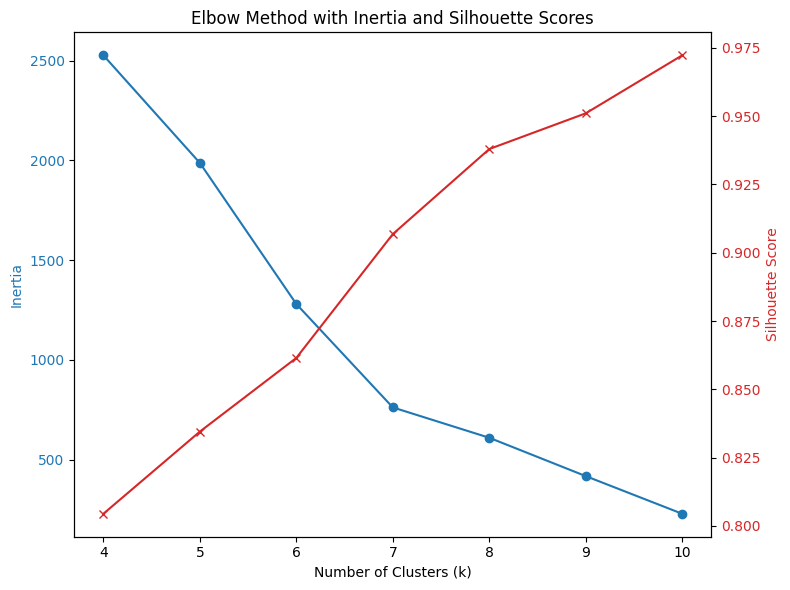

In [ ]:
# visualize the result
plot_elbow_silhouette(inertia_values, silhouette_scores)

In [ ]:
# KMeans with a higher maximum of iterations and TF-IDF with wit stopwords and defined unigrams and bigrams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(data['cleaned_categories'])

inertia_values = []
silhouette_scores = []
k_range = range(4, 11)  # Test k values from 4 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=3000)
    kmeans.fit(X)

    inertia = kmeans.inertia_
    inertia_values.append(inertia)
    silhouette = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette)
    print(f"Clusters: {k}")
    show_results(inertia, silhouette)

Clusters: 4
Inertia: 3861.3975
Silhouette Score: 0.7620

Clusters: 5
Inertia: 3181.7191
Silhouette Score: 0.7925

Clusters: 6
Inertia: 2571.9786
Silhouette Score: 0.8164

Clusters: 7
Inertia: 1888.9386
Silhouette Score: 0.8648

Clusters: 8
Inertia: 1039.3214
Silhouette Score: 0.9318

Clusters: 9
Inertia: 802.4846
Silhouette Score: 0.9462

Clusters: 10
Inertia: 533.1587
Silhouette Score: 0.9597



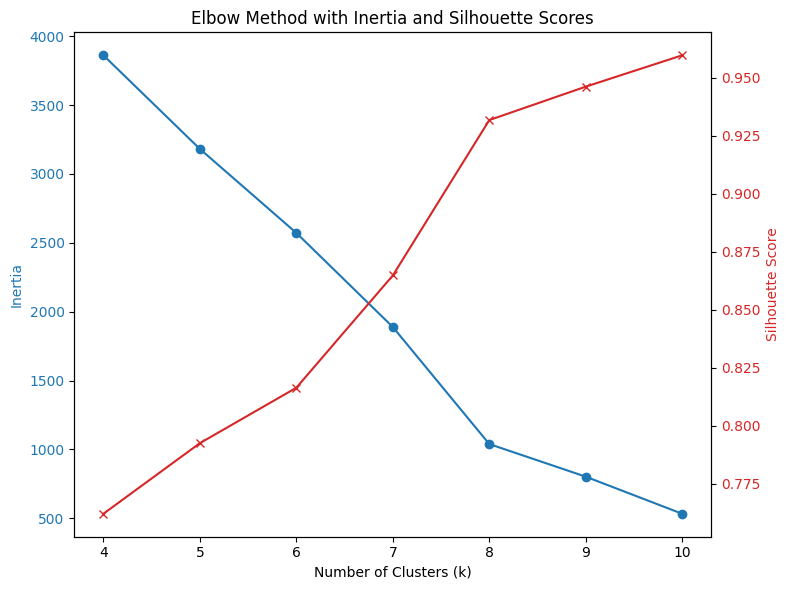

In [ ]:
# visualize the result
plot_elbow_silhouette(inertia_values, silhouette_scores)

In [ ]:
# Same version of KMeans and TF-IDF, but without the definion of stopwords
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(data['cleaned_categories'])

inertia_values = []
silhouette_scores = []
k_range = range(4, 11)  # Test k values from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=3000, n_init=12)
    kmeans.fit(X)

    inertia = kmeans.inertia_
    inertia_values.append(inertia)
    silhouette = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette)
    print(f"Clusters: {k}")
    show_results(inertia, silhouette)

Clusters: 4
Inertia: 3861.4065
Silhouette Score: 0.7620

Clusters: 5
Inertia: 3039.9395
Silhouette Score: 0.8085

Clusters: 6
Inertia: 2324.1390
Silhouette Score: 0.8759

Clusters: 7
Inertia: 1720.5657
Silhouette Score: 0.8993

Clusters: 8
Inertia: 1039.4113
Silhouette Score: 0.9318

Clusters: 9
Inertia: 770.0854
Silhouette Score: 0.9453

Clusters: 10
Inertia: 533.2486
Silhouette Score: 0.9597



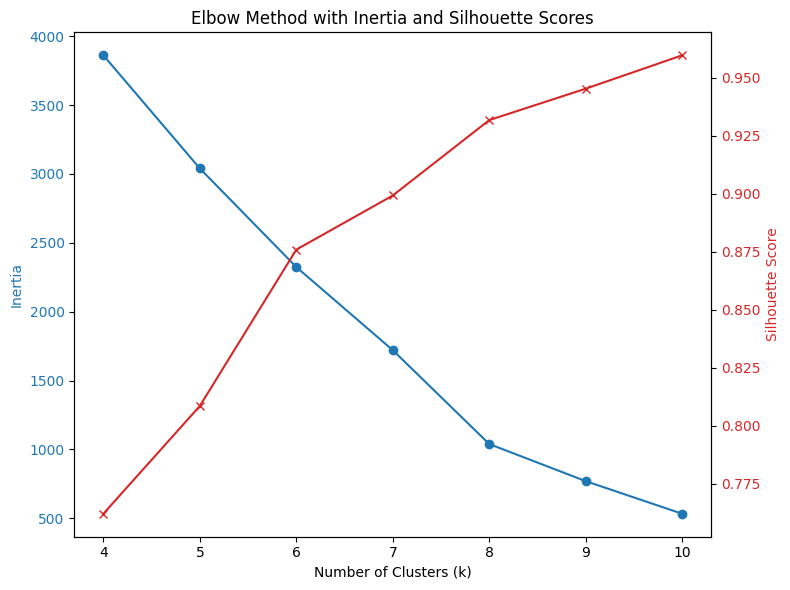

In [ ]:
# visualize the result
plot_elbow_silhouette(inertia_values, silhouette_scores)

### With LDA

Latent Dirichlet Allocation

#### Helper Methods



In [ ]:
def visualize_lda_topics(lda_model, num_topics):
    """Visualizes LDA topics using word clouds.

    Args:
      lda_model: The trained LDA model.
      num_topics: The number of topics to visualize.

    Returns:
      None
    """
    for topic_id in range(num_topics):
        topic_words = dict(lda_model.show_topic(topic_id, topn=10))  # Get top 10 words for each topic
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(topic_words)

        plt.figure(figsize=(4, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_id}')
        plt.show()

In [ ]:
english_stopwords = stopwords.words('english')


def remove_stopwords(name):
    """Removes stop words from a given name.

    Args:
      name(string): The input text as a string.

    Returns:
      The name with stop words removed as a string.
    """

    text = ' '.join([word for word in name.split() if word not in english_stopwords])  # Remove word if it's a stopword
    return text

In [ ]:
def cleanup_names():
    """Cleans up names in the 'name' column of the DataFrame.
    
    Returns:
      None
    """

    # Convert to lowercase first
    data['modified_name'] = data['name'].str.lower()
    # Remove all special characters and numbers using regex
    data['modified_name'] = data['modified_name'].apply(lambda x: re.sub('[^a-z ]+', '', x))
    # remove short words in the name as those are storage or display sizes or other unhelpful information
    data['modified_name'] = data['modified_name'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 3 or word == "tv"]))
    # remove all amazon words
    data['modified_name'] = data['modified_name'].str.replace(r'amazon', '', regex=True)
    # remove words which can create a bias when categorizing
    data['modified_name'] = data['modified_name'].str.replace(r'\b(includes|special|offer|offers|wifi|display|brand|allnew|bsztbk|all|new|ppi|blue|white|black|magenta|silver|monochrome|aluminum|)\b', '', regex=True)

#### Pre-Processing

#### Train

In [ ]:
# cleanup names to get better results
cleanup_names()

# remove english stopwords
data['modified_name'] = data['modified_name'].apply(remove_stopwords)

# show a bunch of words to check the cleanup
data['modified_name'].sample(10)

,modified_name
25376,fire tv fire tv
3333,kindle ereader glarefree touchscreen
8073,fire tablet
25440,fire tv fire tv
10240,fire tablet
10078,fire tablet
13377,fire tablet
8011,fire tablet
7761,fire tablet
32,fire tablet


In [ ]:
# Tokenize the text
tokenized_texts = [text.split() for text in data['modified_name']]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(tokenized_texts)

# create a corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [ ]:
# Let's create 8 topics
num_topics = 7

# Train the LDA model
lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=500)

#### Evaluate

In [ ]:
# Have a look on the generated topics
for topic in lda_model.print_topics():
    print(topic)

(0, '0.246*"paperwhite" + 0.169*"kindle" + 0.130*"touchscreen" + 0.122*"reader" + 0.122*"ebook" + 0.035*"ereader" + 0.029*"voyage" + 0.027*"highresolution" + 0.023*"builtin" + 0.023*"light"')
(1, '0.928*"echo" + 0.014*"glarefree" + 0.010*"leather" + 0.009*"cover" + 0.006*"charging" + 0.006*"oasis" + 0.004*"merlot" + 0.003*"cable" + 0.003*"angle" + 0.003*"micro"')
(2, '0.101*"fire" + 0.100*"usb" + 0.099*"adapter" + 0.098*"kindle" + 0.097*"charger" + 0.094*"tablets" + 0.092*"power" + 0.091*"ereaders" + 0.091*"oem" + 0.091*"official"')
(3, '0.248*"bluetooth" + 0.248*"tap" + 0.248*"portable" + 0.248*"speaker" + 0.004*"tangerine" + 0.004*"alexa" + 0.000*"voyage" + 0.000*"fire" + 0.000*"tablet" + 0.000*"kindle"')
(4, '0.493*"fire" + 0.492*"tv" + 0.002*"generation" + 0.002*"release" + 0.001*"standing" + 0.001*"protective" + 0.001*"red" + 0.001*"cayenne" + 0.001*"caseth" + 0.001*"refurbished"')
(5, '0.492*"fire" + 0.492*"tablet" + 0.008*"gen" + 0.008*"android" + 0.000*"tangerine" + 0.000*"alex

In [ ]:
# Compute perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity:.4f}")

Perplexity: -2.3035


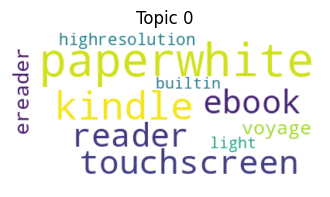

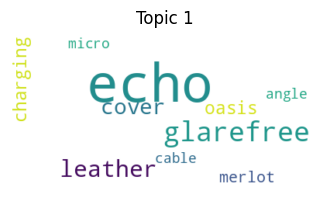

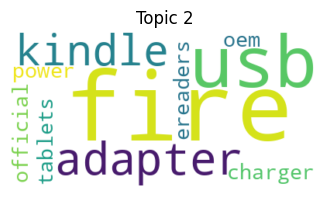

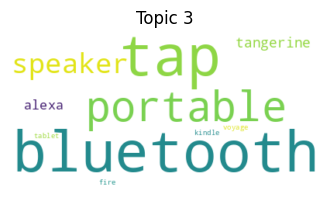

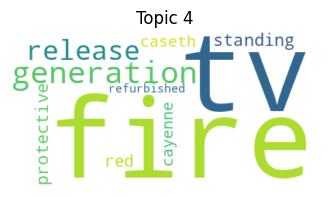

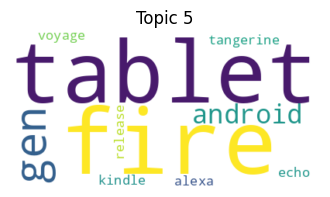

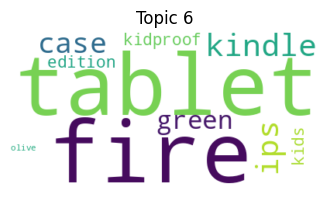

In [ ]:
# Create a wordcloud for a better understanding of the generated groups
visualize_lda_topics(lda_model, num_topics=num_topics)

In [ ]:
# Get topic distribution for each document
topic_distributions = [lda_model[doc] for doc in corpus]

# Add a new column to your DataFrame with the dominant topic for each document
data['dominant_topic'] = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions]

In [ ]:
# Let's see how the groups are mixed
data['dominant_topic'].value_counts()

,count
dominant_topic,
5,14554
0,4038
1,3398
6,2724
4,2550
3,339
2,264


In [ ]:
# Show randomly 6 product names to check the assigned dominant_topic
sample_products = data.groupby('dominant_topic').apply(lambda x: x.sample(n=6))
sample_products['name']

<ipython-input-186-bde6b53f4afc>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_products = data.groupby('dominant_topic').apply(lambda x: x.sample(n=6))


dominant_topic       
0               18528    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                19287    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                19324    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                19928    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                19588    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                19565    Amazon Kindle Paperwhite - eBook reader - 4 GB...
1               22560                            Echo (White) Echo (White)
                24137                            Echo (White) Echo (White)
                22064                            Echo (White) Echo (White)
                22342                            Echo (White) Echo (White)
                21596                            Echo (White) Echo (White)
                23372                            Echo (White) Echo (White)
2               3220     Amazon 5W USB Official OEM Charger and Power A...
                3141     Amazon 5W USB Official OEM Charger and Power A...
                3196     Amazon 5W USB Official OEM Charger and Power A...
                3226     Amazon 5W USB Official OEM Charger and Power A...
                3224     Amazon 5W USB Official OEM Charger and Power A...
                3169     Amazon 5W USB Official OEM Charger and Power A...
3               25092    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                25232    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                25194    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                25082    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                3041     Fire HD 8 Tablet with Alexa, 8 HD Display, 32 ...
                25248    Amazon - Amazon Tap Portable Bluetooth and Wi-...
4               27647                        Amazon Fire Tv Amazon Fire Tv
                26847                        Amazon Fire Tv Amazon Fire Tv
                27303                        Amazon Fire Tv Amazon Fire Tv
                15497    Amazon Kindle Touch Leather Case (4th Generati...
                25707                        Amazon Fire Tv Amazon Fire Tv
                25910                        Amazon Fire Tv Amazon Fire Tv
5               438      All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
                10491    Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                4749     Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                4264     Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                9738     Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                10990    Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
6               16638    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
                16985    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
                16550    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
                14673    Brand New Amazon Kindle Fire 16gb 7 Ips Displa...
                16532    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
                15283    Brand New Amazon Kindle Fire 16gb 7 Ips Displa...
Name: name, dtype: object

In [ ]:
# After visual check of the groups, add a readable name for the group
mapping = {
    0: "Amazon Kindle Paperwhite",
    1: "Amazon Echo White",
    2: "Charger & Accessories",
    3: "Amazon Portable Speaker",
    4: "Amazon Fire Tv",
    5: "Amazon Fire Tablet",
    6: "Amazon Fire Kids Edition"}

data['predicted_categorie'] = data['dominant_topic'].map(mapping)

In [ ]:
# Show randomly 6 product names to check the assigned categories
sample_products = data.groupby('predicted_categorie').apply(lambda x: x.sample(n=6))
sample_products['name']

<ipython-input-188-331e4543fe4e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_products = data.groupby('predicted_categorie').apply(lambda x: x.sample(n=6))


predicted_categorie            
Amazon Echo White         23027                            Echo (White) Echo (White)
                          23588                            Echo (White) Echo (White)
                          23699                            Echo (White) Echo (White)
                          22641                            Echo (White) Echo (White)
                          24452                            Echo (White) Echo (White)
                          23914                            Echo (White) Echo (White)
Amazon Fire Kids Edition  16514    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
                          16277    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
                          15172    Brand New Amazon Kindle Fire 16gb 7 Ips Displa...
                          16643    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
                          15307    Brand New Amazon Kindle Fire 16gb 7 Ips Displa...
                          16712    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
Amazon Fire Tablet        4862     Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                          21177    Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                          10072    Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                          3917     Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                          3749     Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
                          7154     Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...
Amazon Fire Tv            27449                        Amazon Fire Tv Amazon Fire Tv
                          27793                        Amazon Fire Tv Amazon Fire Tv
                          27119                        Amazon Fire Tv Amazon Fire Tv
                          26045                        Amazon Fire Tv Amazon Fire Tv
                          26913                        Amazon Fire Tv Amazon Fire Tv
                          27019                        Amazon Fire Tv Amazon Fire Tv
Amazon Kindle Paperwhite  17296    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                          17242    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                          20965    Kindle Paperwhite E-reader - White, 6 High-Res...
                          18398    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                          19115    Amazon Kindle Paperwhite - eBook reader - 4 GB...
                          17540    Amazon Kindle Paperwhite - eBook reader - 4 GB...
Amazon Portable Speaker   25024    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                          25208    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                          25190    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                          25298    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                          25305    Amazon - Amazon Tap Portable Bluetooth and Wi-...
                          25268    Amazon - Amazon Tap Portable Bluetooth and Wi-...
Charger & Accessories     24843    Amazon 9W PowerFast Official OEM USB Charger a...
                          3225     Amazon 5W USB Official OEM Charger and Power A...
                          3168     Amazon 5W USB Official OEM Charger and Power A...
                          24850    Amazon 9W PowerFast Official OEM USB Charger a...
                          3108     Amazon 5W USB Official OEM Charger and Power A...
                          24835    Amazon 9W PowerFast Official OEM USB Charger a...
Name: name, dtype: object

## Cleanup dataset

In [ ]:
# Let's have a look on the dataset size and types of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27867 entries, 0 to 27866
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 27867 non-null  object
 1   brand                27867 non-null  object
 2   categories           27867 non-null  object
 3   reviews.rating       27867 non-null  int64 
 4   reviews.text         27867 non-null  object
 5   reviews.title        27863 non-null  object
 6   predicted_sentiment  27867 non-null  object
 7   cleaned_categories   27867 non-null  object
 8   modified_name        27867 non-null  object
 9   dominant_topic       27867 non-null  int64 
 10  predicted_categorie  27867 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.3+ MB


In [ ]:
# let's remove now everything what's maybe not needed anymore
data = data.drop(['cleaned_categories', 'categories', 'modified_name', 'dominant_topic'], axis=1)
data.head()

,name,categories,reviews.rating,reviews.text,reviews.title,predicted_sentiment,predicted_categorie
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,This product so far has not disappointed. My c...,Kindle,positive,Amazon Fire Tablet
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,great for beginner or experienced person. Boug...,very fast,positive,Amazon Fire Tablet
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,positive,Amazon Fire Tablet
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",4,I've had my Fire HD 8 two weeks now and I love...,Good!!!,positive,Amazon Fire Tablet
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,positive,Amazon Fire Tablet


After categorizing, save the data to be able to start from that point later.

In [ ]:
# save dataset in a csv file for a later usage
data.to_csv('lists/reviews_with_predicted_sentiment_category.csv', index=False)